In [103]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization,Input,Bidirectional,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [80]:
file_path = 'arramooz-master/verbs_with_madhi_mudhori_amar.csv'
df = pd.read_csv(file_path, encoding='utf-8')


In [81]:
# Hapus kolom 'Triliteral'
df.drop(columns=['Triliteral'], inplace=True)


In [83]:
# Tokenizer
# Tokenizer untuk input
num_words= 5000
tokenizer_input = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer_input.fit_on_texts(df['Unvocalized'])

X = tokenizer_input.texts_to_sequences(df['Unvocalized'])
X_padded = pad_sequences(X, padding='post')


X = tokenizer_input.texts_to_sequences(df['Unvocalized'])
X_padded = pad_sequences(X, padding='post')

# Tokenizer untuk masing-masing target
tokenizer_madhi = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer_mudhori = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer_amar = Tokenizer(num_words=num_words, oov_token='OOV')

# Fit tokenizer pada setiap kolom target
tokenizer_madhi.fit_on_texts(df['Madhi'])
tokenizer_mudhori.fit_on_texts(df['Mudhori'])
tokenizer_amar.fit_on_texts(df['Amar'])

# Konversi target menjadi token integer
y_madhi = np.array([seq[0] for seq in tokenizer_madhi.texts_to_sequences(df['Madhi'])])
y_mudhori = np.array([seq[0] for seq in tokenizer_mudhori.texts_to_sequences(df['Mudhori'])])
y_amar = np.array([seq[0] for seq in tokenizer_amar.texts_to_sequences(df['Amar'])])



# Persiapan Data

In [84]:

# Split dataset
X_train, X_val, y_madhi_train, y_madhi_val, y_mudhori_train, y_mudhori_val, y_amar_train, y_amar_val = train_test_split(
    X, y_madhi, y_mudhori, y_amar, test_size=0.2, random_state=42
)



In [85]:

# Buat dataset TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, (y_madhi_train, y_mudhori_train, y_amar_train)))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, (y_madhi_val, y_mudhori_val, y_amar_val)))

# Shuffle dan batch dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


In [45]:
print("Word Index:")
print(word_index)

print("\nSequences X_train:")
print(y_train_seq)

print("\nSequences X_validation:")
print(y_val_seq)

print("\nInput Dimension:")
print(input_dim)

Word Index:
{'<OOV>': 1, 'قصر': 2, 'قدم': 3, 'خبر': 4, 'قبل': 5, 'جِدْ': 6, 'اِعْنِ': 7, 'دِنْ': 8, 'ضِعْ': 9, 'رِعْ': 10, 'غِرْ': 11, 'قدر': 12, 'رخم': 13, 'أكل': 14, 'حلم': 15, 'نحل': 16, 'عدل': 17, 'هش': 18, 'نعم': 19, 'غرب': 20, 'يمن': 21, 'سخن': 22, 'نزل': 23, 'يسر': 24, 'ورع': 25, 'زمر': 26, 'وضع': 27, 'غار': 28, 'شعر': 29, 'حسر': 30, 'نجد': 31, 'نقب': 32, 'طلق': 33, 'وقر': 34, 'قر': 35, 'راح': 36, 'رمد': 37, 'هَشَّ': 38, 'يَهِشُّ': 39, 'اِهْشِشْ': 40, 'يَغْرِبُ': 41, 'اِغْرِبْ': 42, 'يَيْمِنُ': 43, 'اِيمِنْ': 44, 'يَقْدِمُ': 45, 'اِقْدِمْ': 46, 'سِعْ': 47, 'قِرْ': 48, 'يَقْصِرُ': 49, 'اِقْصِرْ': 50, 'قَرَّ': 51, 'يَقِرُّ': 52, 'اِقْرِرْ': 53, 'يَخْبِرُ': 54, 'اِخْبِرْ': 55, 'رَاحَ': 56, 'يَرِيحُ': 57, 'رِحْ': 58, 'يَقْبِلُ': 59, 'اِقْبِلْ': 60, 'عبر': 61, 'سمل': 62, 'عبد': 63, 'ضرب': 64, 'رطب': 65, 'علب': 66, 'نشر': 67, 'حل': 68, 'سفه': 69, 'خلف': 70, 'علق': 71, 'فرض': 72, 'نكب': 73, 'خرم': 74, 'نبذ': 75, 'نخر': 76, 'شجن': 77, 'حرد': 78, 'ودع': 79, 'جدل': 80, 'صدر': 81, 'كدر': 8

In [86]:
for x_batch, y_batch in train_dataset.take(1):
    print("Input Shape:", x_batch.shape)
    print("Madhi Target Shape:", y_batch[0].shape)
    print("Mudhori Target Shape:", y_batch[1].shape)
    print("Amar Target Shape:", y_batch[2].shape)


Input Shape: (32, 1)
Madhi Target Shape: (32,)
Mudhori Target Shape: (32,)
Amar Target Shape: (32,)


# Preprocessing Data

# Model Building

In [112]:
# Parameter model
vocab_size = len(tokenizer_input.word_index) + 1
embedding_dim = 128
lstm_units = 64

output_vocab_size = {
    'madhi': len(tokenizer_madhi.word_index) + 1,
    'mudhori': len(tokenizer_mudhori.word_index) + 1,
    'amar': len(tokenizer_amar.word_index) + 1
}

# Input layer
input_layer = Input(shape=(X_padded.shape[1],), name="Input")

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

# Bidirectional LSTM
bilstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_layer)
# Output layers
madhi_output = Dense(output_vocab_size['madhi'], activation='softmax', name="Madhi")(bilstm_layer)
mudhori_output = Dense(output_vocab_size['mudhori'], activation='softmax', name="Mudhori")( bilstm_layer)
amar_output = Dense(output_vocab_size['amar'], activation='softmax', name="Amar")(bilstm_layer)

# Model
model = Model(inputs=input_layer, outputs=[madhi_output, mudhori_output, amar_output])

# Compile model
model.compile(
    optimizer='adam',
    loss={
        'Madhi': 'sparse_categorical_crossentropy',
        'Mudhori': 'sparse_categorical_crossentropy',
        'Amar': 'sparse_categorical_crossentropy'
    },
    metrics={
        'Madhi': ['accuracy'],
        'Mudhori': ['accuracy'],
        'Amar': ['accuracy']
    }
)
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 1, 128)    │  1,009,920 │ Input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 128)       │     98,816 │ embedding_14[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Madhi (Dense)       │ (None, 9846)      │  1,270,134 │ bidirectional_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mudhori (Dense)     │ (None, 8949)      │  1,154,421 │ bidirectional_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Amar (Dense)        │ (None, 8790)      │  1,133,910 │ bidirectional_13… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,667,201 (17.80 MB)

 Trainable params: 4,667,201 (17.80 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
# Latih model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1,
    callbacks=[lr_scheduler]
)
# Evaluasi model
loss, madhi_loss, mudhori_loss, amar_loss, madhi_acc, mudhori_acc, amar_acc = model.evaluate(val_dataset)

print("Total Loss:", loss)
print("Madhi Loss:", madhi_loss)
print("Mudhori Loss:", mudhori_loss)
print("Amar Loss:", amar_loss)
print("Madhi Accuracy:", madhi_acc)
print("Mudhori Accuracy:", mudhori_acc)
print("Amar Accuracy:", amar_acc)


Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - Amar_accuracy: 0.3289 - Amar_loss: 7.8917 - Madhi_accuracy: 0.4351 - Madhi_loss: 7.7565 - Mudhori_accuracy: 0.3507 - Mudhori_loss: 7.8040 - loss: 23.4522 - val_Amar_accuracy: 0.3553 - val_Amar_loss: 6.8822 - val_Madhi_accuracy: 0.4629 - val_Madhi_loss: 6.2806 - val_Mudhori_accuracy: 0.3741 - val_Mudhori_loss: 6.6700 - val_loss: 19.8337 - learning_rate: 0.0010
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - Amar_accuracy: 0.3648 - Amar_loss: 6.0187 - Madhi_accuracy: 0.4618 - Madhi_loss: 5.2287 - Mudhori_accuracy: 0.3778 - Mudhori_loss: 5.8343 - loss: 17.0817 - val_Amar_accuracy: 0.3557 - val_Amar_loss: 7.1630 - val_Madhi_accuracy: 0.4624 - val_Madhi_loss: 6.3106 - val_Mudhori_accuracy: 0.3741 - val_Mudhori_loss: 6.9745 - val_loss: 20.4388 - learning_rate: 0.0010
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - Amar_accuracy: 0.3529 - Amar_loss: 5.6060 - Madhi_accuracy: 0.4528 - Madhi_loss: 4.7437 - Mudhori_accuracy: 

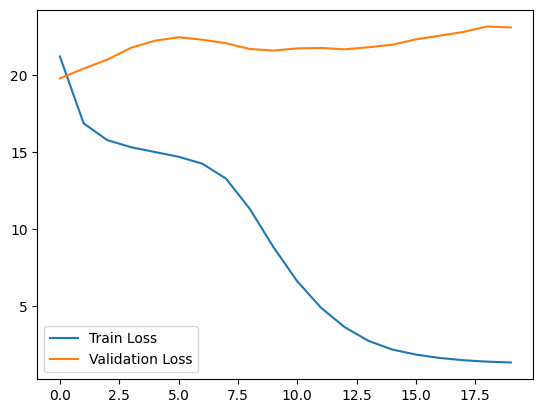

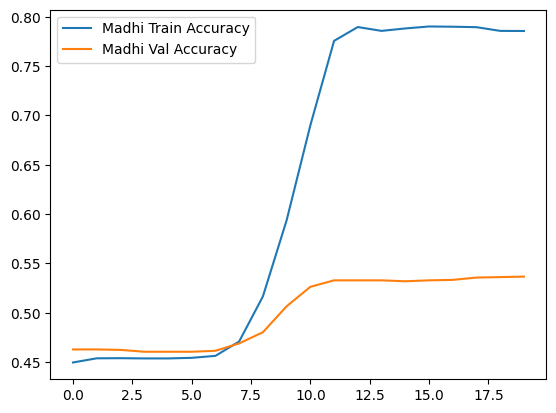

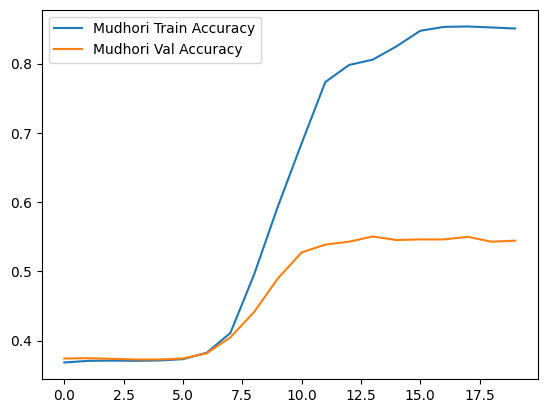

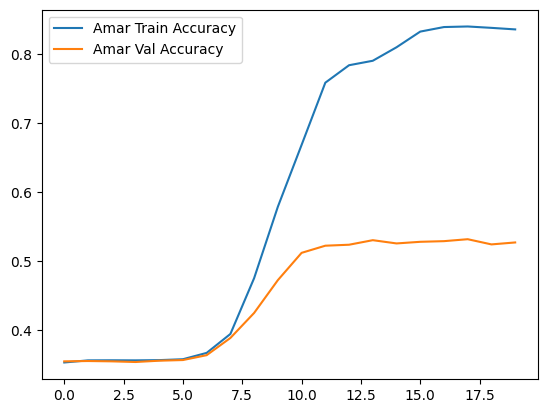

In [90]:


# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['Madhi_accuracy'], label='Madhi Train Accuracy')
plt.plot(history.history['val_Madhi_accuracy'], label='Madhi Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['Mudhori_accuracy'], label='Mudhori Train Accuracy')
plt.plot(history.history['val_Mudhori_accuracy'], label='Mudhori Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['Amar_accuracy'], label='Amar Train Accuracy')
plt.plot(history.history['val_Amar_accuracy'], label='Amar Val Accuracy')
plt.legend()
plt.show()

In [73]:
# Input baru
new_input = ["عمل"]  # Contoh kata kerja

# Tokenisasi dan padding
new_input_seq = pad_sequences(tokenizer.texts_to_sequences(new_input), maxlen=max_len, padding='post')
print("Tokenized & Padded Input:", new_input_seq)


Tokenized & Padded Input: [[1814    0    0    0    0    0]]


In [74]:
# Prediksi
predictions = model.predict(new_input_seq)

# Ambil prediksi token untuk setiap output
predicted_madhi = tf.argmax(predictions[0], axis=-1).numpy()
predicted_mudhori = tf.argmax(predictions[1], axis=-1).numpy()
predicted_amar = tf.argmax(predictions[2], axis=-1).numpy()

print("Predicted Madhi (token):", predicted_madhi)
print("Predicted Mudhori (token):", predicted_mudhori)
print("Predicted Amar (token):", predicted_amar)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
Predicted Madhi (token): [1]
Predicted Mudhori (token): [1]
Predicted Amar (token): [1]


In [98]:
# Input baru
new_input = ["زال"]  # Contoh kata baru tanpa harakat
new_input_seq = tokenizer_input.texts_to_sequences(new_input)
new_input_padded = pad_sequences(new_input_seq, maxlen=X_padded.shape[1], padding='post')

# Prediksi
predictions = model.predict(new_input_padded)

# Konversi hasil prediksi ke kata
madhi_pred = tokenizer_madhi.index_word[np.argmax(predictions[0])]
mudhori_pred = tokenizer_mudhori.index_word[np.argmax(predictions[1])]
amar_pred = tokenizer_amar.index_word[np.argmax(predictions[2])]

print(f"Input: {new_input[0]}")
print(f"Madhi: {madhi_pred}")
print(f"Mudhori: {mudhori_pred}")
print(f"Amar: {amar_pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Input: زال
Madhi: زَالَ
Mudhori: يَزِيلُ
Amar: زِلْ
